# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 100)



import warnings
warnings.filterwarnings('ignore')

In [2]:
def sign(x):
    if x > 0:
        return(1)
    elif x == 0:
        return(0)
    else:
        return(-1)

## Знакомство с данными

In [3]:
data = pd.read_csv('PD-data-train.csv', sep=';')
oot = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc2.csv', sep=';')

Семплы и размеры выборок

In [4]:
data.head(8)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0
5,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,100,5,5,5,[1-100],350000.0,1,0,0,0,0
6,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,27,7,7,7,[1-100],35000.0,3,0,0,0,0
7,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,31,30,30,30,[1-100],10000.0,2,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

Видно, что в датасете есть как числовые, так и один категориальный признак.

In [6]:
oot.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [7]:
data.shape, oot.shape

((32395, 37), (200, 36))

In [8]:
data.describe()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
count,32395.000000,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,3.239500e+04,32395.000000,32395.000000,32395.000000,32395.0,32395.000000
mean,136955.533601,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,4.188071e+05,3.937304e+04,3.731104e+06,9.007101e+06,3.044379e+07,1.627389e+07,1.336024e+07,8.096597e+05,1.610857e+06,3.307750e+06,1.911815e+07,2.419023e+07,3.149311e+06,4.983973e+06,1.508316e+07,9.737877e+05,97.121500,78.644822,15.010341,15.010341,15.010341,1.366509e+06,11.946535,0.021670,0.000093,0.0,0.064547
std,79370.573366,1.274402e+08,1.227227e+08,1.156651e+08,1.231798e+07,7.848929e+06,1.941027e+07,6.014715e+06,1.938021e+07,1.565298e+06,4.843389e+05,1.902355e+07,3.642723e+07,6.331020e+07,3.729649e+07,3.851823e+07,8.222404e+06,1.067265e+07,8.895007e+06,4.603456e+07,5.917809e+07,2.764231e+07,1.359236e+07,3.793929e+07,1.493730e+07,75.555398,46.522534,9.546511,9.546511,9.546511,1.502438e+07,86.341847,0.342715,0.009623,0.0,0.245729
min,7.000000,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,-1.034000e+07,-4.778100e+07,0.000000e+00,0.000000e+00,0.000000e+00,-1.160400e+07,-3.413000e+06,0.000000e+00,-4.780300e+07,-7.501000e+07,0.000000e+00,-3.068000e+06,-2.700000e+06,0.000000e+00,-2.500000e+05,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.0,0.000000
25%,67912.000000,1.019950e+07,9.130250e+06,8.844000e+06,0.000000e+00,0.000000e+00,2.112500e+05,-9.400000e+05,1.420000e+05,0.000000e+00,0.000000e+00,1.010000e+05,0.000000e+00,2.854500e+06,8.100000e+05,4.722500e+05,0.000000e+00,4.100000e+04,9.400000e+04,4.532500e+05,1.634000e+06,0.000000e+00,0.000000e+00,6.722500e+05,0.000000e+00,35.000000,35.000000,6.000000,6.000000,6.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
50%,137527.000000,3.233500e+07,2.970350e+07,2.840800e+07,0.000000e+00,0.000000e+00,1.231500e+06,-1.260000e+05,8.500000e+05,4.100000e+04,0.000000e+00,7.040000e+05,0.000000e+00,1.109450e+07,4.714500e+06,3.028500e+06,0.000000e+00,2.640000e+05,6.730000e+05,3.528000e+06,7.231000e+06,0.000000e+00,3.610000e+05,3.678000e+06,0.000000e+00,79.000000,77.000000,14.000000,14.000000,14.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
75%,205633.500000,8.887675e+07,8.309500e+07,7.991425e+07,0.000000e+00,0.000000e+00,4.574750e+06,0.000000e+00,3.543750e+06,2.910000e+05,0.000000e+00,3.176000e+06,3.490000e+05,3.423000e+07,1.754600e+07,1.200325e+07,0.000000e+00,1.188500e+06,3.025750e+06,1.760775e+07,2.541800e+07,0.000000e+00,3.816750e+06,1.424575e+07,0.000000e+00,137.000000,133.000000,24.000000,24.000000,24.000000,3.000000e+04,2.000000,0.000000,0.000000,0.0,0.000000
max,274623.000000,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,3.979500e+07,1.485559e+09,1.630344e+09,3.175805e+09,2.890917e+09,1.711586e+09,3.336220e+08,1.271337e+09,2.470140e+08,1.739879e+09,3.349389e+09,2.919676e+09,3.

### Оценим соотношение классов

In [9]:
data['default_12m'].value_counts()

0    30304
1     2091
Name: default_12m, dtype: int64

Уровень дефолт-рейта в выборке = 6,4546%

In [10]:
data['default_12m'].values.mean()

0.06454699799351751

Тут видим дисбаланс, на oot выборке соотношение классов 1 к 2

## Визуализация данных


разделим на дефолты и не дефолты

перед этим стантартизируем наши данные, что бы сравнивать дефолты и не дефолты в одной размерности

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
def plot_data(data):
    y = data['default_12m']
    scaler = StandardScaler()
    data_mini = data.drop(['default_12m', 'ul_staff_range'], axis = 1)
    data_scal = scaler.fit_transform(data_mini)
    data_scal_pd = pd.DataFrame(data_scal, columns = data_mini.columns)
    undefault = data_scal_pd[y == 0]
    default = data_scal_pd[y == 1]
    for name in data_scal_pd.columns.unique():
        plt.figure(figsize=(20, 6))
        plt.subplot(1,3, 1)
        undefault[name].hist(bins = 100)
        plt.title('undef ' + name)
        plt.subplot(1,3, 2)
        default[name].hist(bins = 100)
        plt.title('def ' + name)
        plt.subplot(1,3, 3)
        plt.title(name)
        undefault[name].hist(bins = 100, label = 'undefault')
        default[name].hist(bins = 100, label = 'default')
        plt.legend()
        plt.show() 

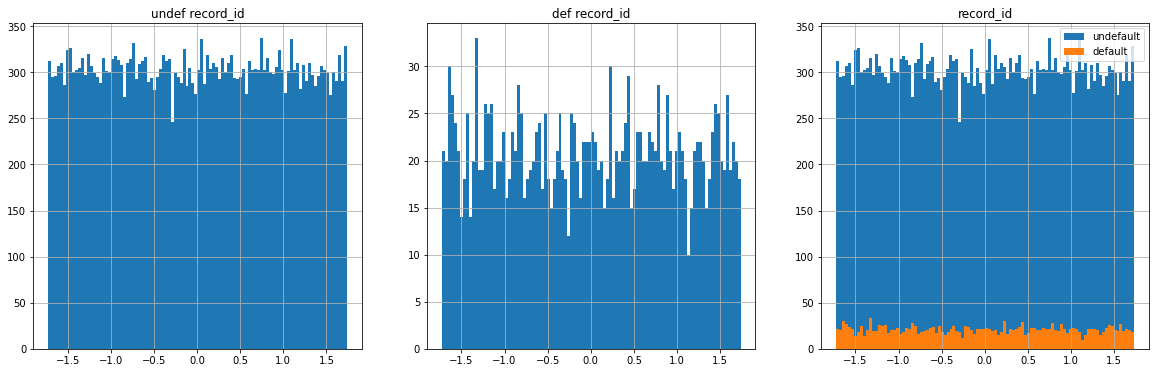

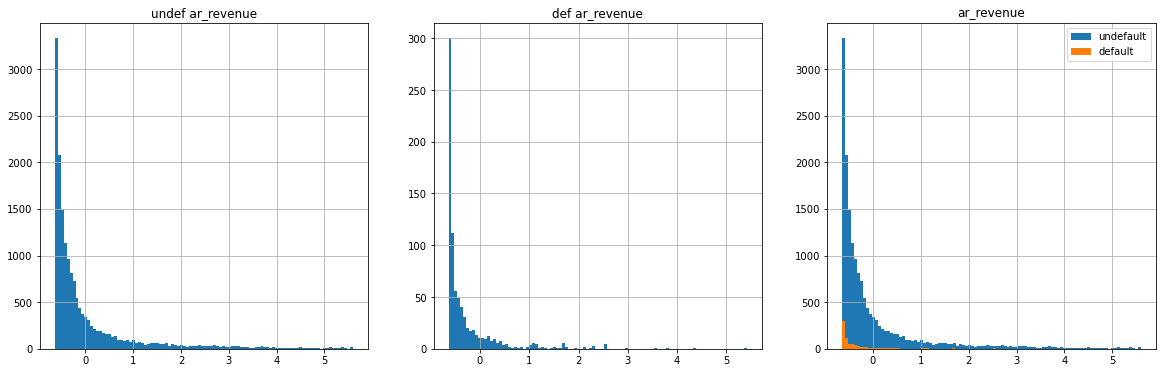

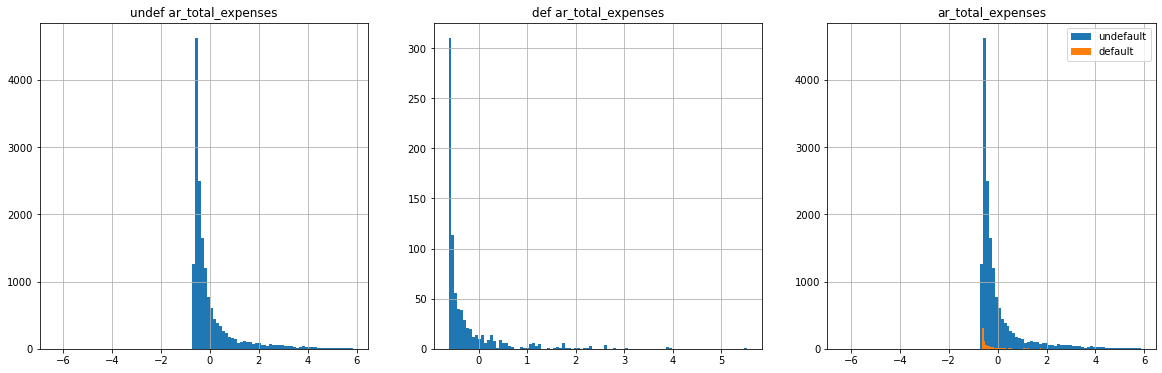

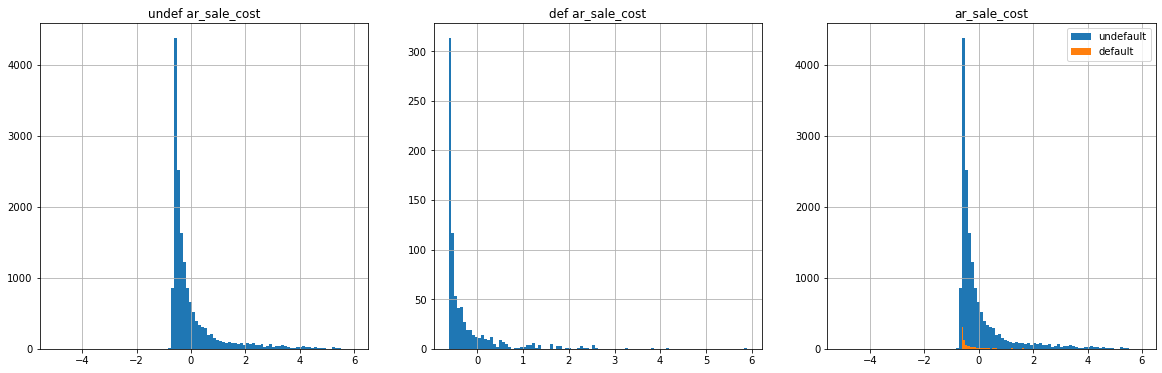

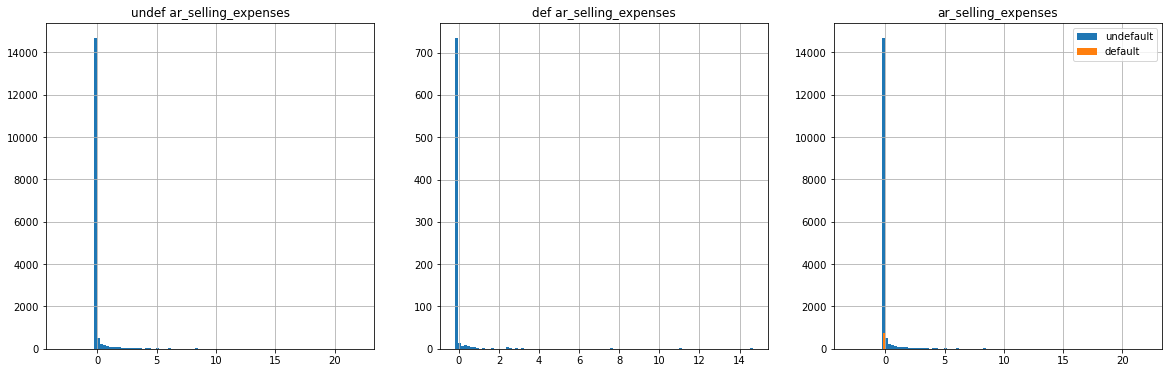

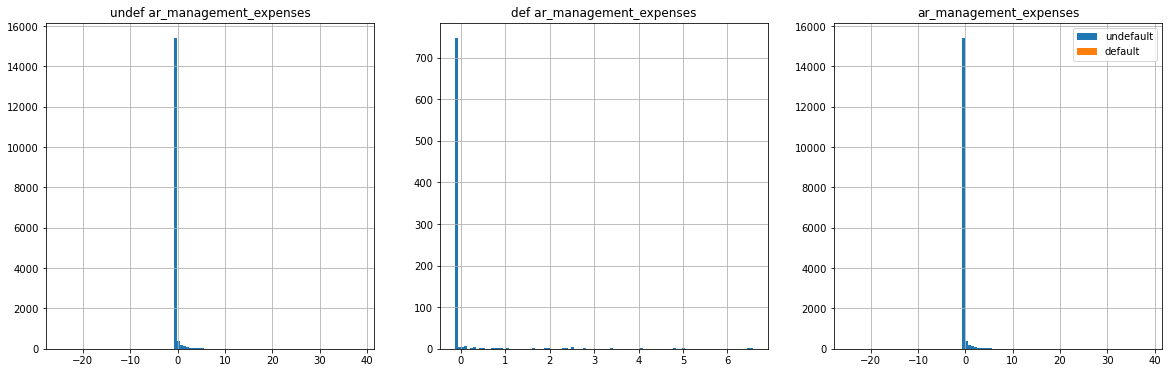

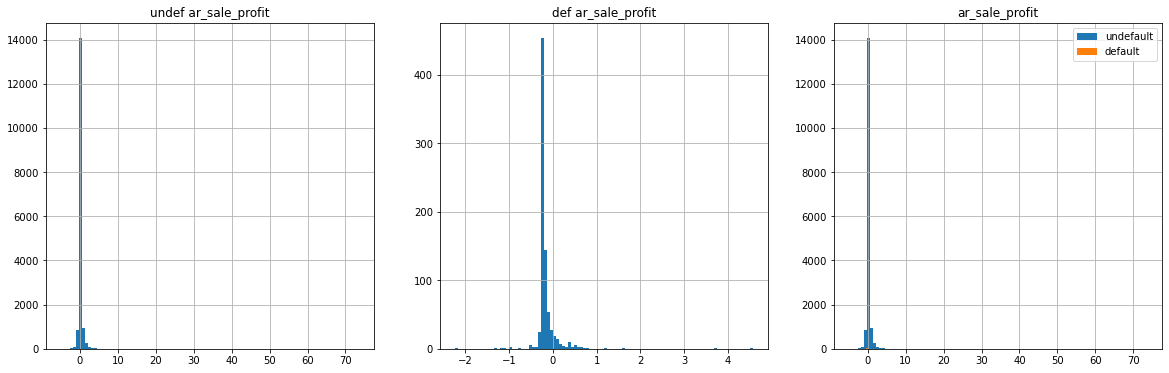

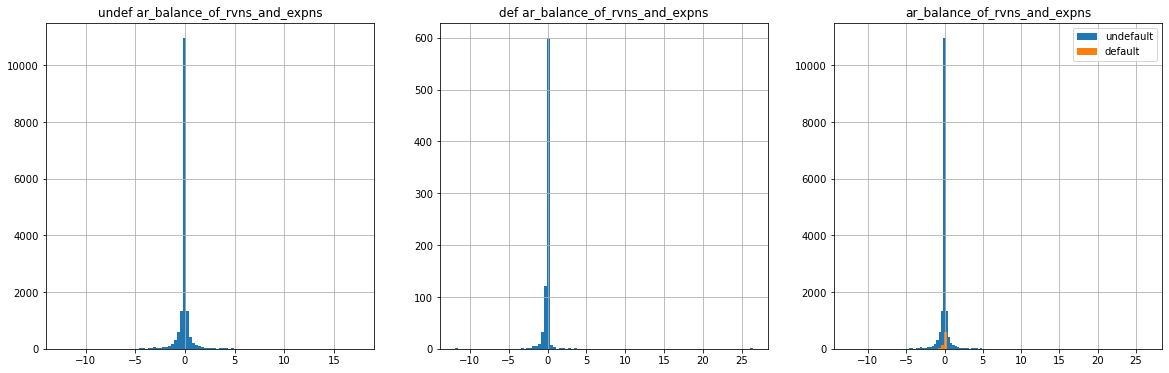

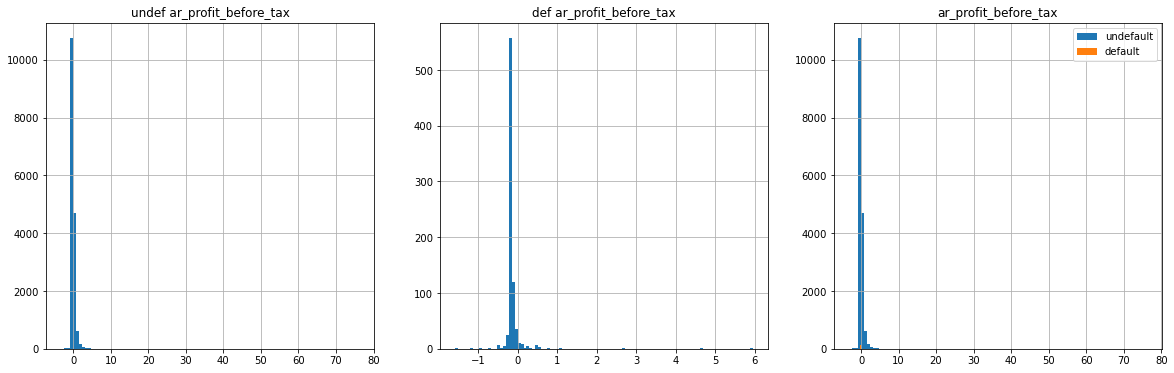

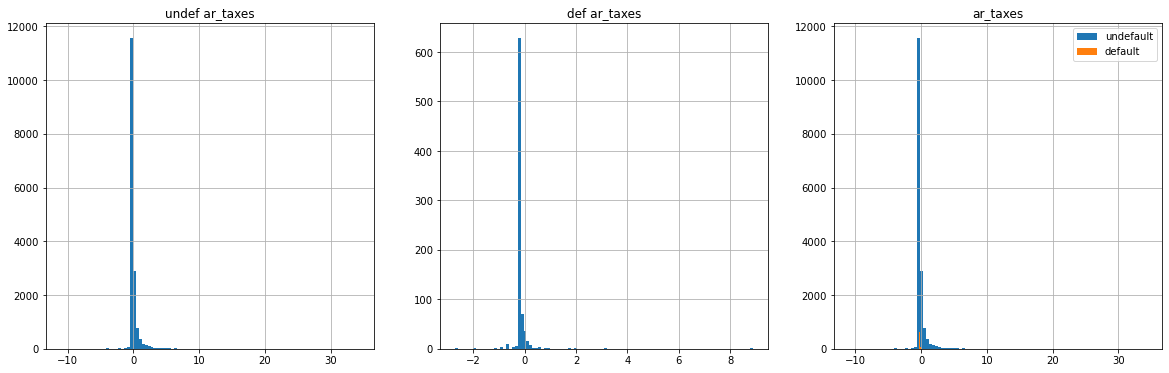

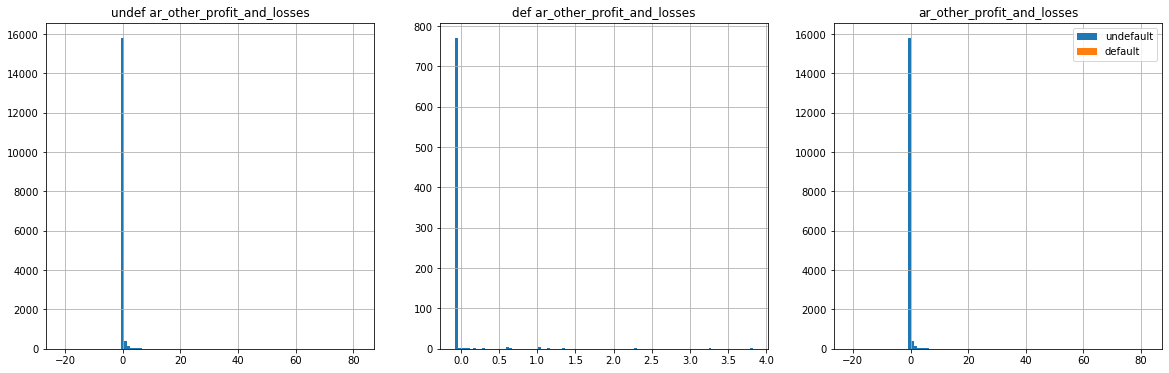

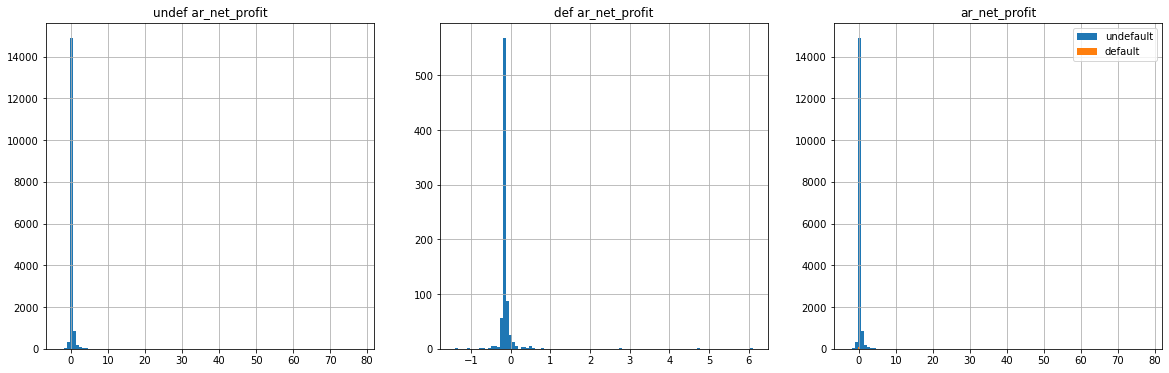

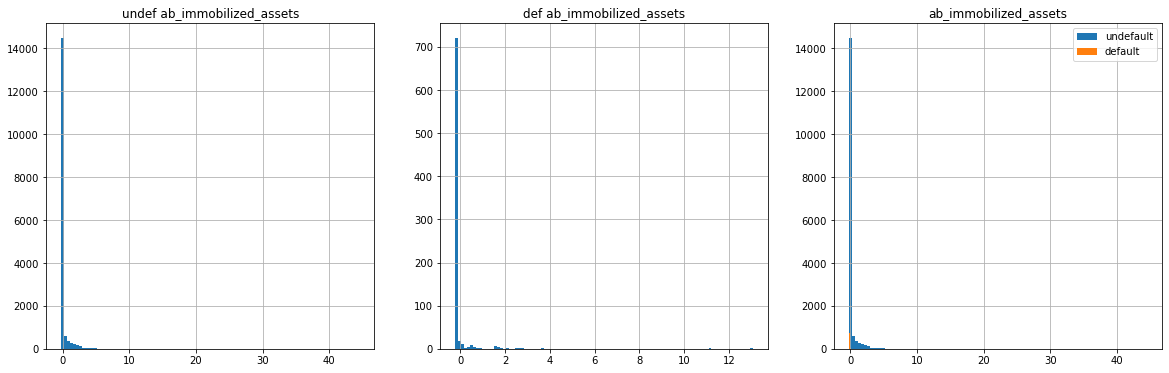

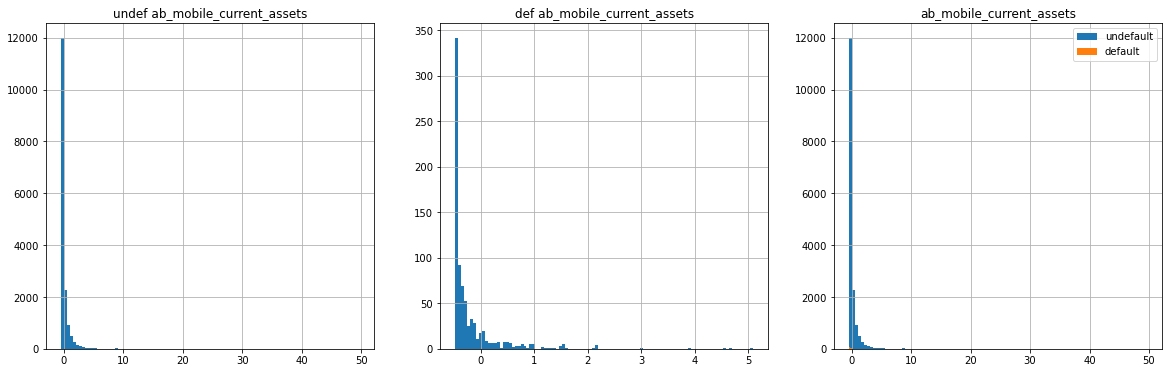

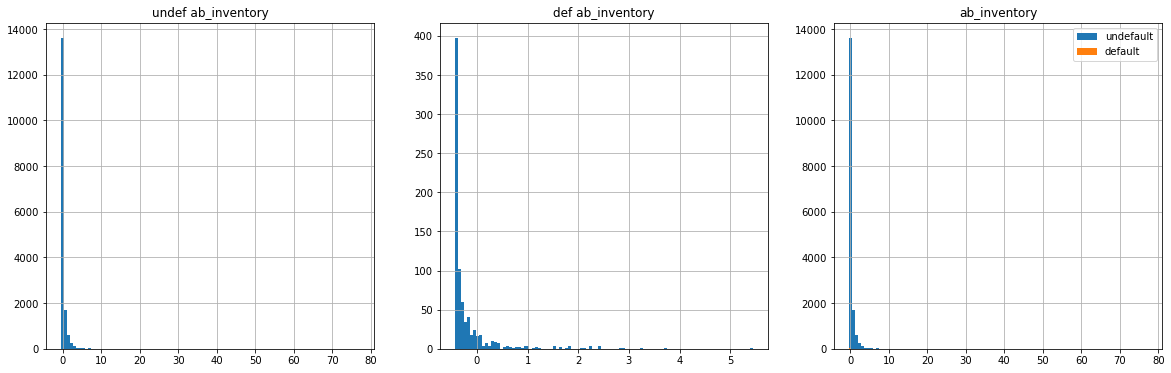

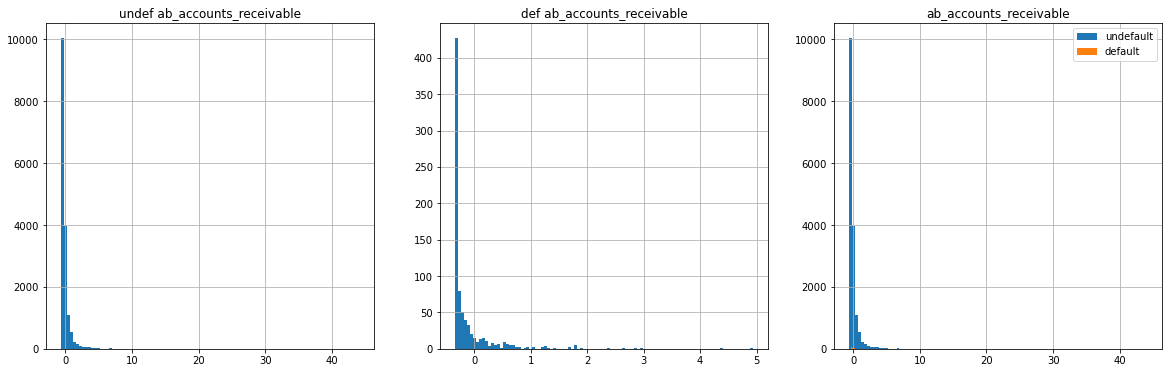

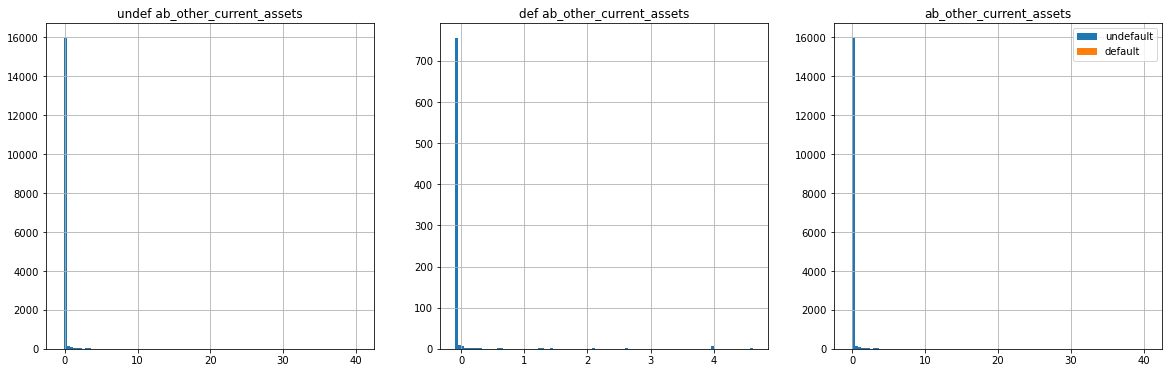

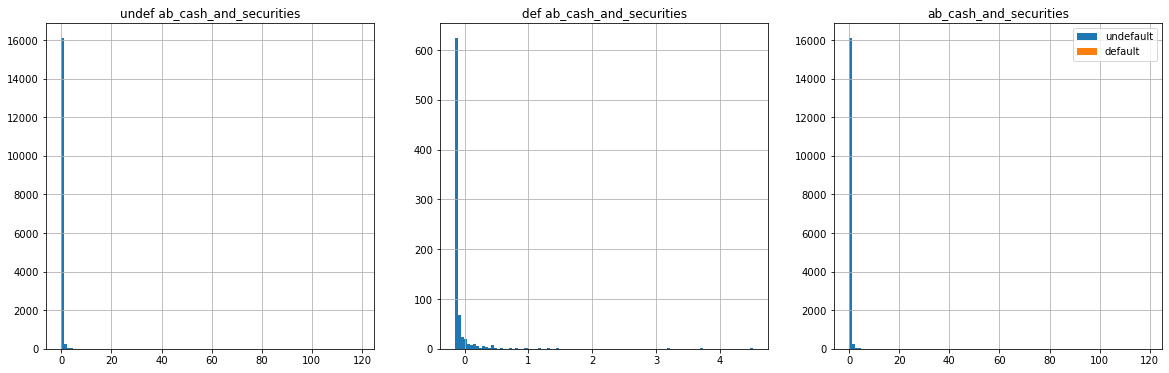

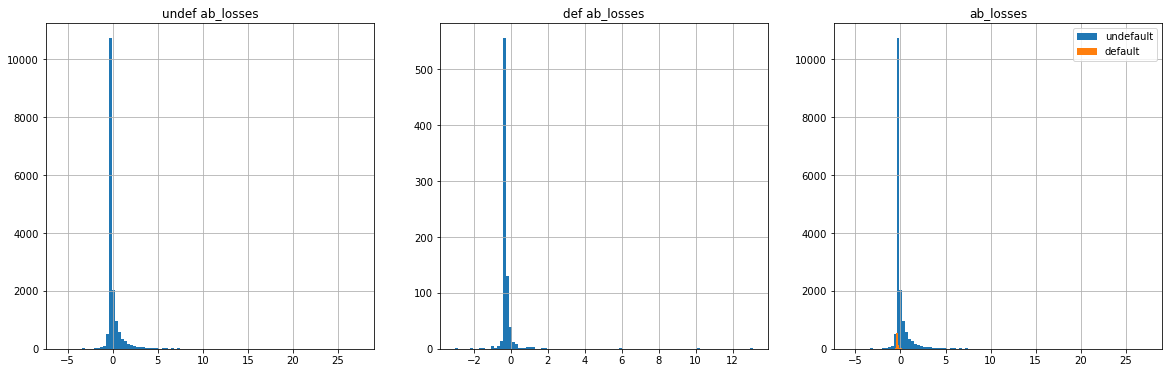

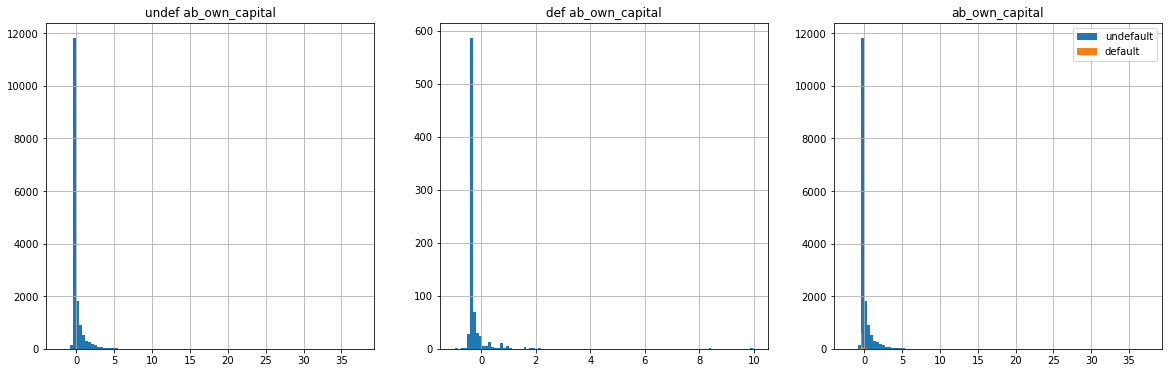

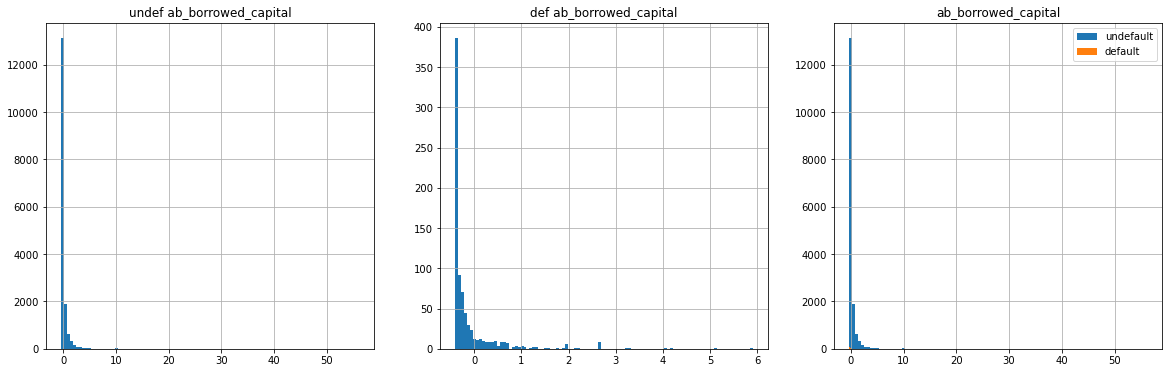

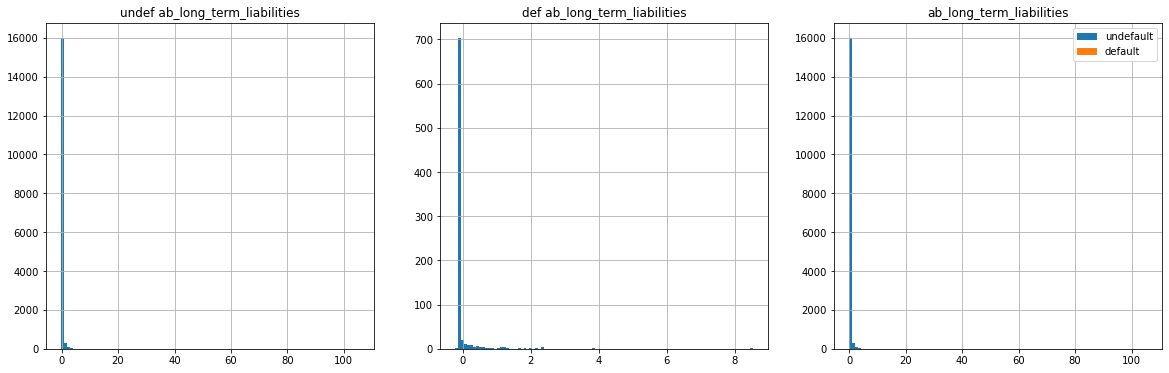

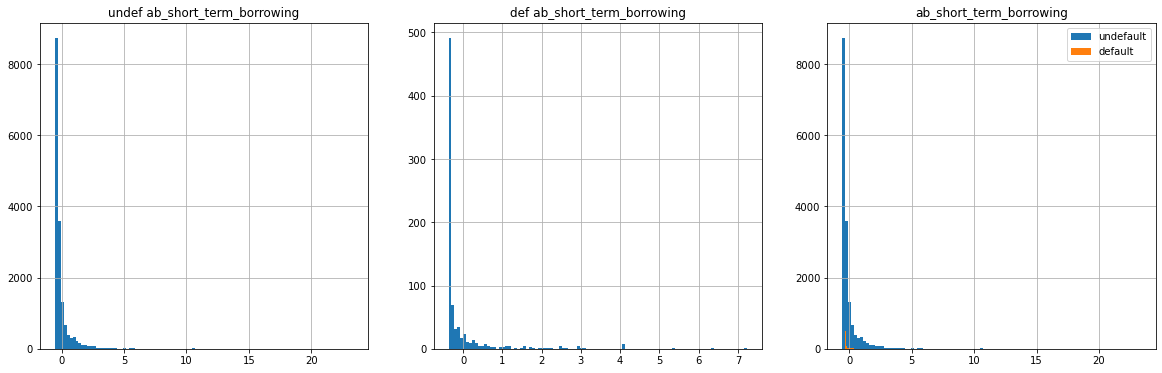

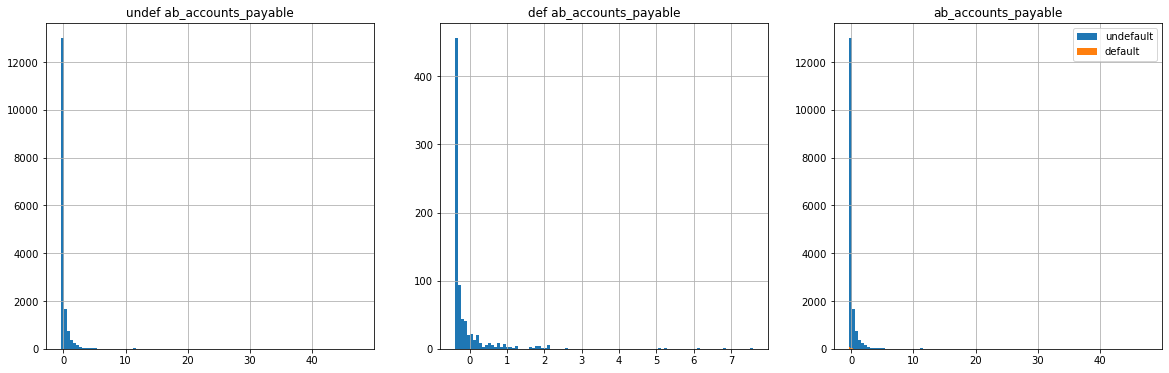

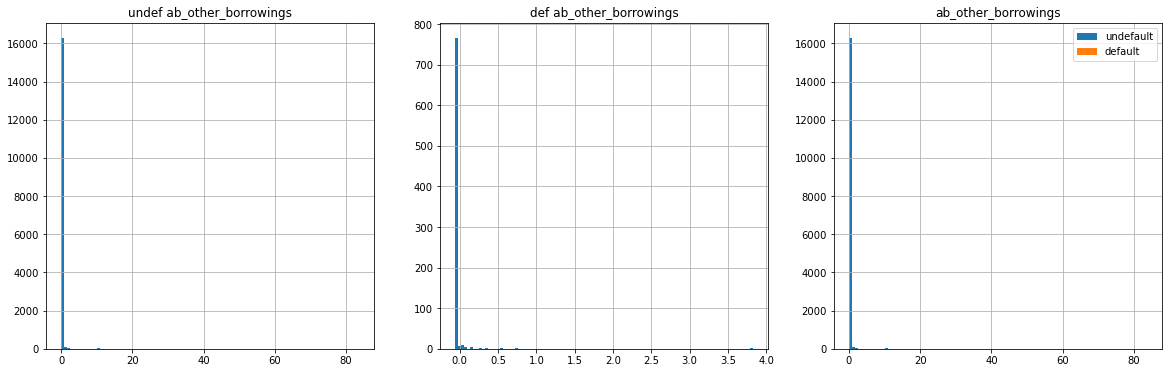

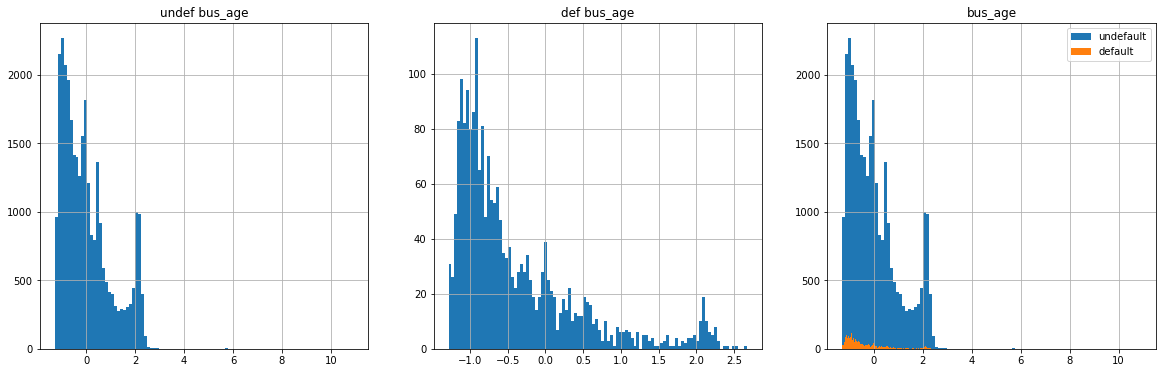

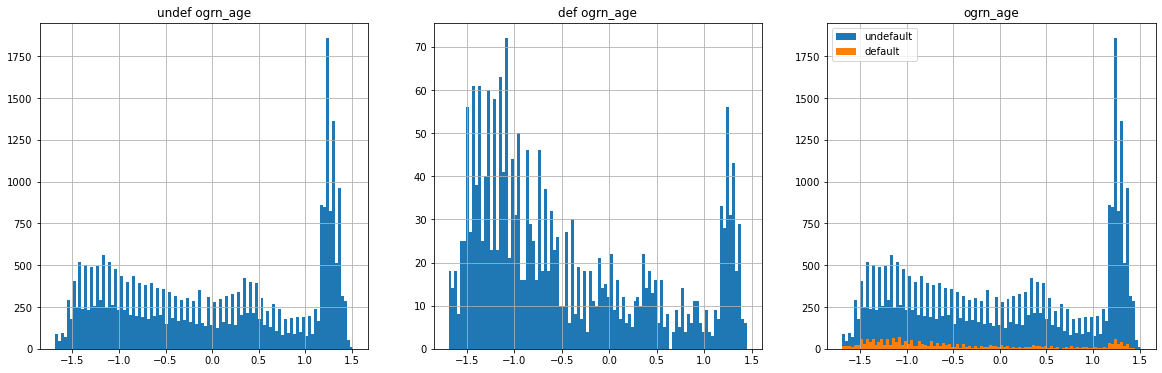

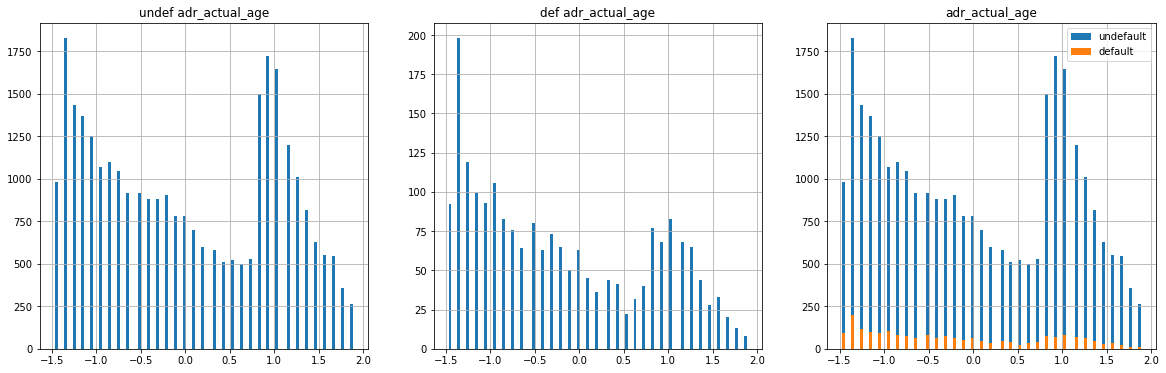

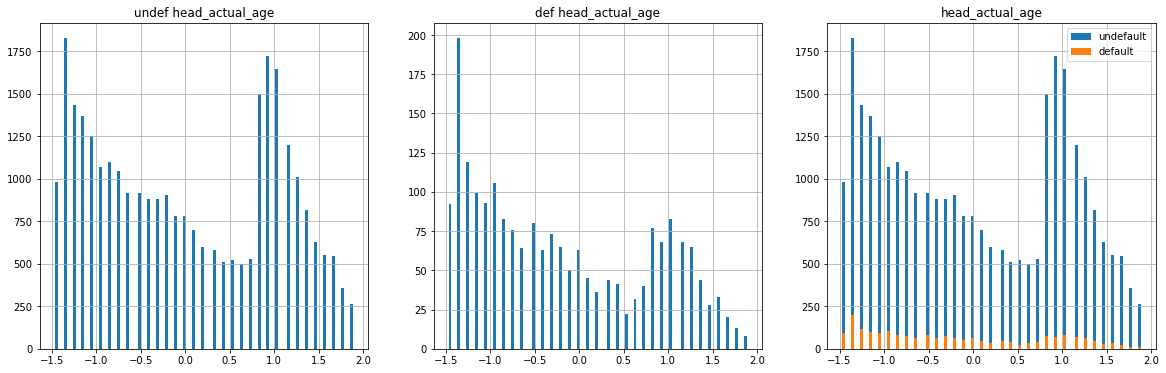

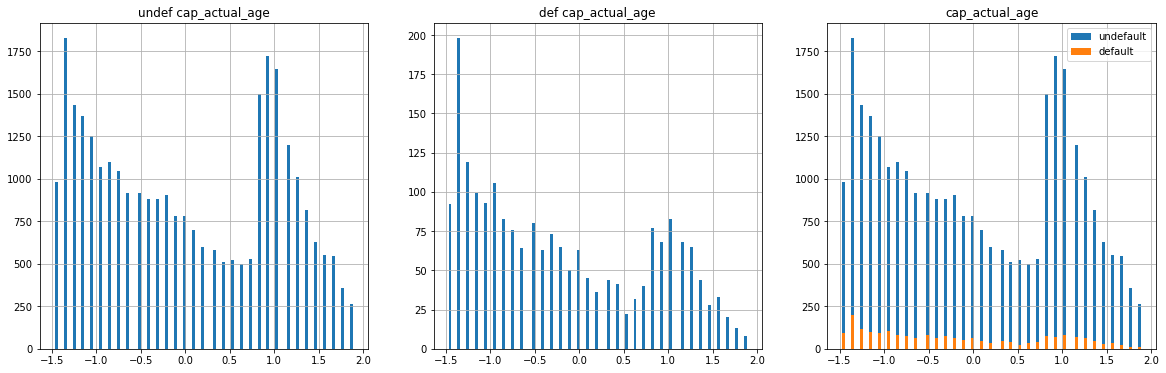

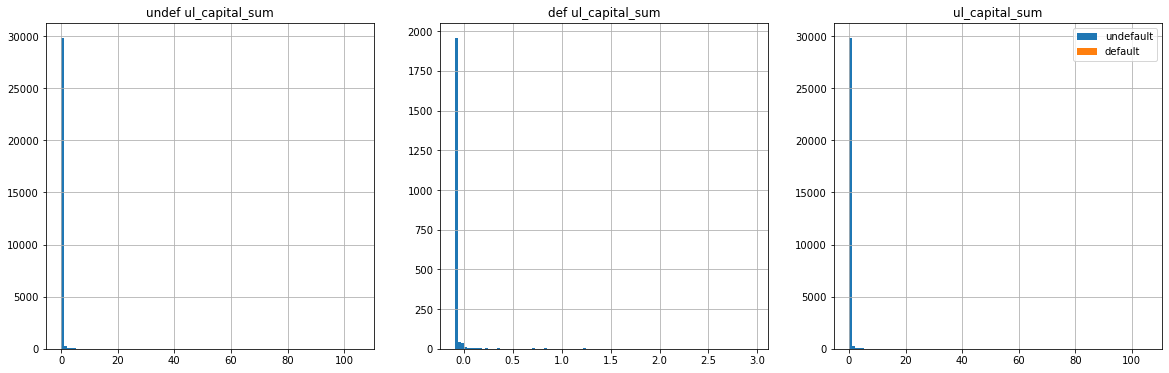

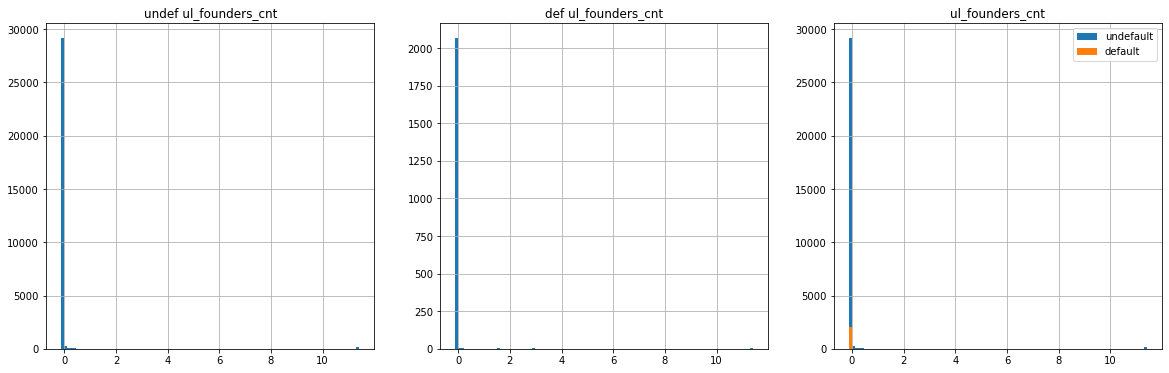

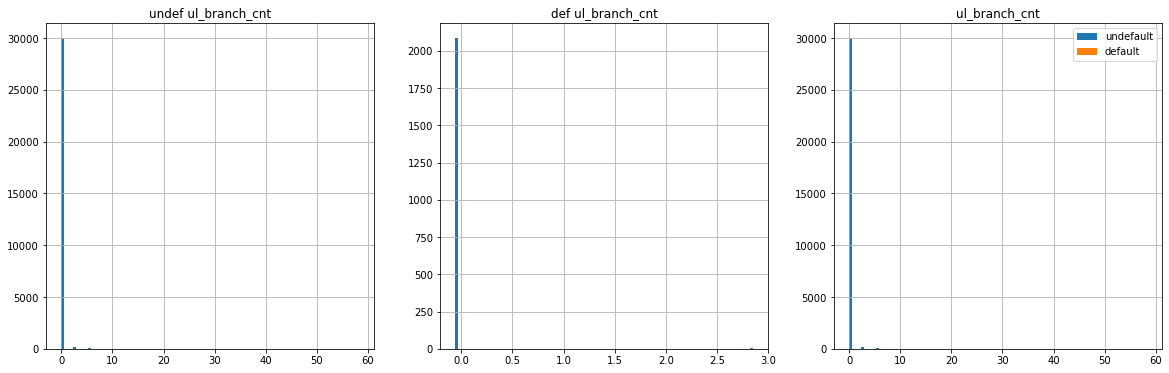

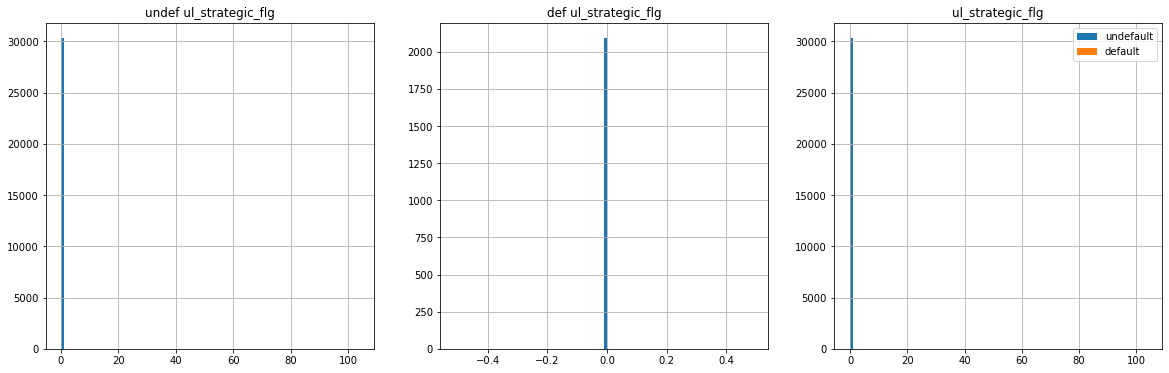

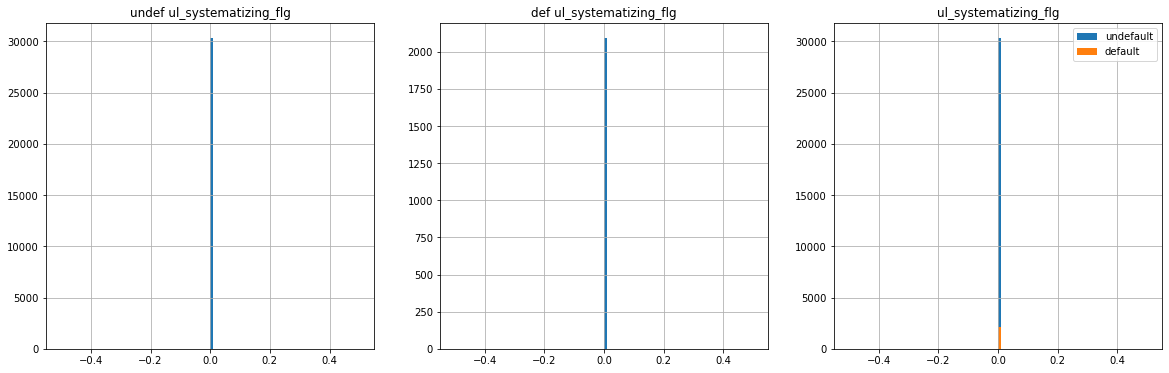

In [13]:
plot_data(data)

На основе этих графиков я лучше понял природу данных, патался найти явное различие между дефолтами и не дефолтами, нашел малоинформативные признаки 
#### 2 одинаковых поля

In [14]:
len(data['cap_actual_age']) - sum(data['cap_actual_age'] == data['head_actual_age'])

0

#### всего 3 значения из 32395 отличны от нуля в ul_strategic_flg

In [15]:
len(data['ul_strategic_flg']) - sum(data['ul_strategic_flg'] == 0) 

3

#### в ul_systematizing_flg все значения нулевые

In [16]:
len(data['ul_systematizing_flg']) - sum(data['ul_systematizing_flg'] == 0) 

0

#### в ul_branch_cnt 0.98 % значений нулевых 

In [17]:
sum(data['ul_branch_cnt'] == 0) / len(data['ul_branch_cnt'])

0.9899984565519371

### Сразу удалим признаки у которых все значения = 0 или который являются дубликатоми друг друга

In [18]:
record_id = oot['record_id']
data = data.drop(['record_id', 'cap_actual_age', 'ul_strategic_flg', 'ul_systematizing_flg', 'ul_branch_cnt'], axis=1)
oot = oot.drop(['record_id', 'cap_actual_age', 'ul_strategic_flg', 'ul_systematizing_flg', 'ul_branch_cnt'], axis=1)

## long list факторов

Попытаемся создать новые факторы

In [19]:
def cou_s(x): # нужно для обработки категориального признака
    if x == '[1-100]':
        return 100
    elif x == '(100-500]' :
        return 500
    else :
        return 1000

Долговая нагрузка (общий долг / прибыль до вычета процентов, налогов)

In [20]:
data['debt burden'] = data['ab_borrowed_capital'] / data['ar_sale_profit']
oot['debt burden'] = oot['ab_borrowed_capital'] / oot['ar_sale_profit']

Коэффициент автономии - насколько организация независима от кредиторов

In [21]:
data['autonomy'] = data['ab_inventory'] / data['ab_own_capital']
oot['autonomy'] = oot['ab_inventory'] / oot['ab_own_capital']

Коэффициент покрытия инвестиций  -  какая часть активов организации финансируется за счет устойчивых источников

In [22]:
data['investment'] = data['ab_own_capital'] + data['ab_borrowed_capital'] / data['ab_inventory']
oot['investment'] = oot['ab_own_capital'] + oot['ab_borrowed_capital'] / oot['ab_inventory']

Коэффициент покрытия активов  - способность организации погасить свои долги за счет имеющихся активов.

In [23]:
data['asset_coverage'] = (data['ab_inventory'] - (data['ab_borrowed_capital'] - data['ab_short_term_borrowing'])) / data['ab_borrowed_capital']
oot['asset_coverage'] = (oot['ab_inventory'] - (oot['ab_borrowed_capital'] - oot['ab_short_term_borrowing'])) / oot['ab_borrowed_capital']

Cредняя зарплата сотрудников

In [24]:
data['mean_sell'] = (data['ar_selling_expenses'] + data['ar_management_expenses']) / data['ul_staff_range'].apply(lambda x: cou_s(x))
oot['mean_sell'] = (oot['ar_selling_expenses'] + oot['ar_management_expenses']) / oot['ul_staff_range'].apply(lambda x: cou_s(x))

Cредняя прибыль акционера

In [25]:
data['mean_shareholder'] = data['ab_losses'] / data['ul_founders_cnt']
oot['mean_shareholder'] = oot['ab_losses'] / oot['ul_founders_cnt']

Cреднее накоплние капитала за год

In [26]:
data['mean_cap'] =  data['ab_own_capital'] / data['bus_age']
oot['mean_cap'] =  oot['ab_own_capital'] / oot['bus_age']

### Проанализируем результаты

Проанализировав результаты понял, что замена -np.inf и np.inf на большые значения не несет в себе противоречия с бизнес логикой и здравым смыслом

In [27]:
data = data.replace(-np.inf, -10000000)
data = data.replace(np.inf, 10000000)

oot = oot.replace(-np.inf, -10000000)
oot = oot.replace(np.inf, 10000000)

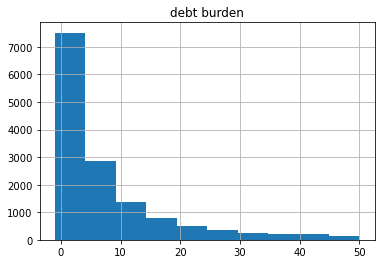

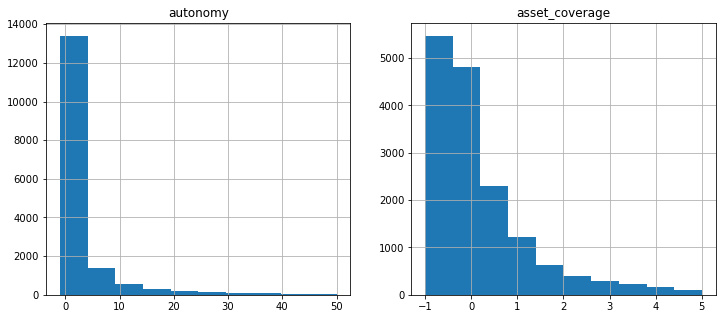

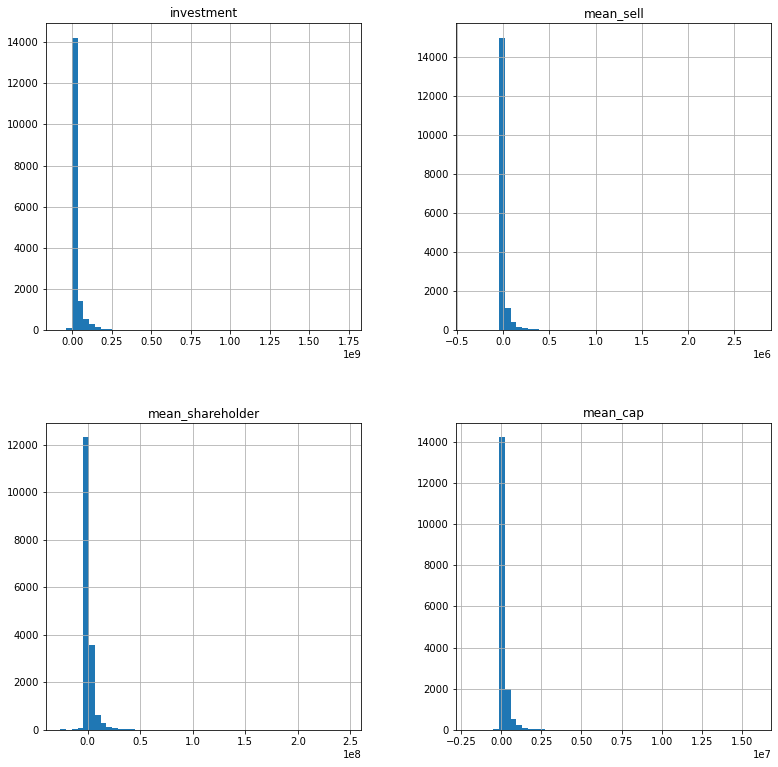

In [28]:
new_col = ['debt burden', 'autonomy', 'asset_coverage', 'investment' , 'mean_sell', 'mean_shareholder', 'mean_cap']
data['debt burden'].hist(range = [-1, 50])
plt.title('debt burden')
plt.show()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
data['autonomy'].hist(range = [-1, 50])
plt.title('autonomy')
plt.subplot(1,2,2)
data['asset_coverage'].hist(range = [-1, 5])
plt.title('asset_coverage')
plt.show()
data[new_col[3:]].hist(bins = 50, figsize=(13, 13))
plt.show()

## Разбиваем на train и test


все клиенты уникальны, так что нет необходимости делать проверку на то, что бы один и тот же признак не попал в train и test

In [29]:
len(record_id) - len(record_id.unique())

0

In [30]:
from sklearn.model_selection import train_test_split

(X_train, 
 X_test) = train_test_split(data, test_size=0.3, stratify = data['default_12m'], 
                                     random_state=0)

## Woe - преобразование

In [31]:
import scorecardpy as sc

Для сохранения монотонности среди признаков (пропуски не учитывались), пришлось вручную объединять 2 соседних бакета

In [32]:
breaks_adj = {
    'ab_cash_and_securities': [100000.0,1100000.0],
    'ab_short_term_borrowing': [1000000.0, 9000000.0],
    'debt burden': [16],
    'ul_capital_sum': [12000.0],
    'autonomy': [1, 7],
    'ar_balance_of_rvns_and_expns': [-3300000.0, -300000.0],
    'ab_borrowed_capital':[2000000.0,38000000.0],
    'asset_coverage' : [1]
    
}
bins = sc.woebin(X_train, y = "default_12m", breaks_list=breaks_adj, random_state = 0)

[INFO] creating woe binning ...
Binning on 22676 rows and 39 columns in 00:00:11


In [33]:
# bins = sc.woebin(X_train, y = "default_12m", random_state = 0)

In [34]:
X_train_woe = sc.woebin_ply(X_train, bins)
X_test_woe = sc.woebin_ply(X_test, bins)
oot_woe = sc.woebin_ply(oot, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


## Проверка на монотонность

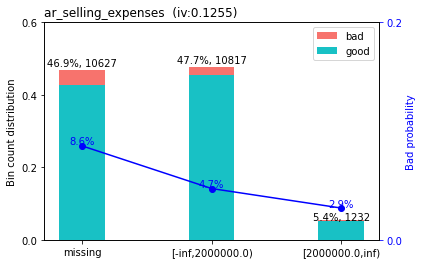

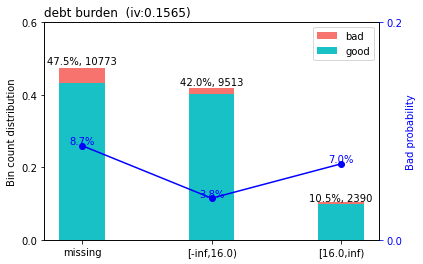

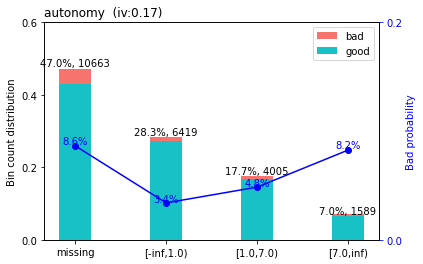

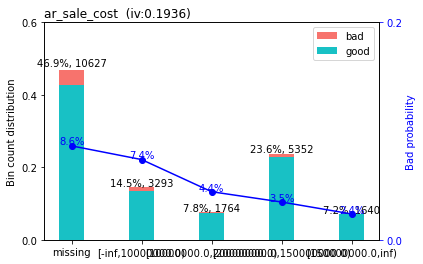

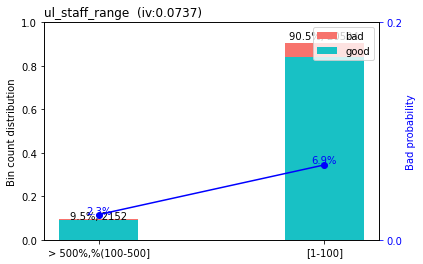

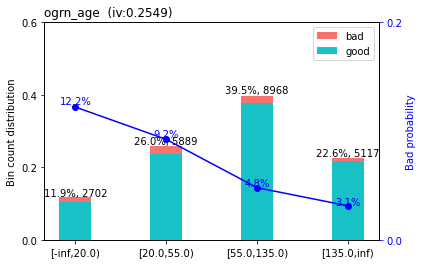

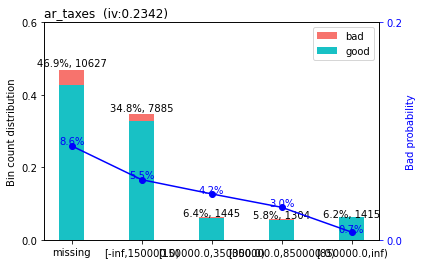

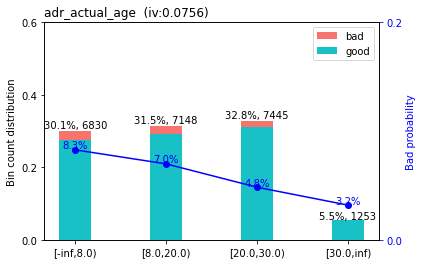

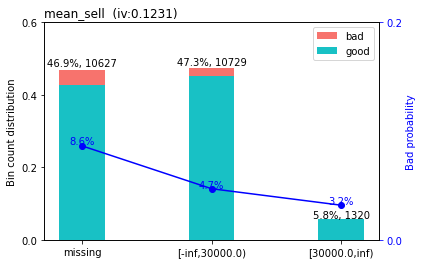

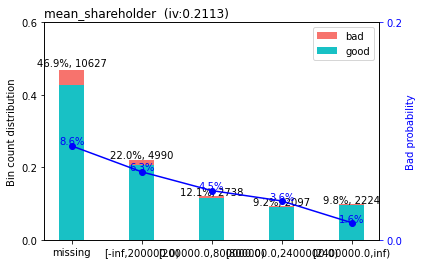

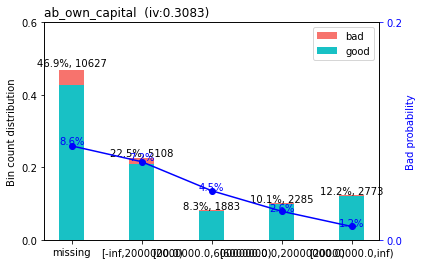

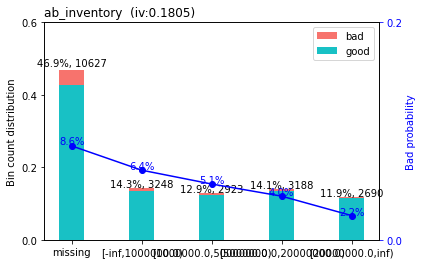

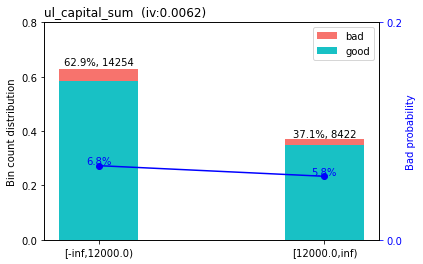

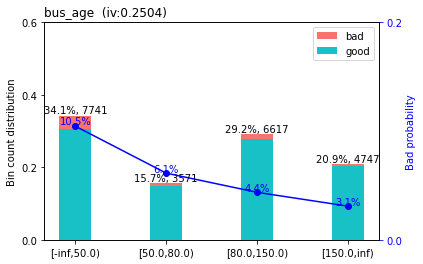

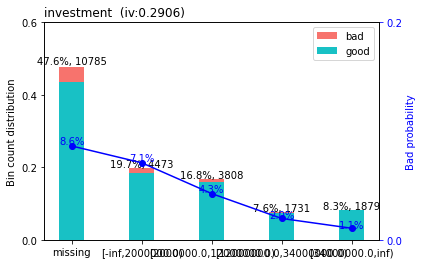

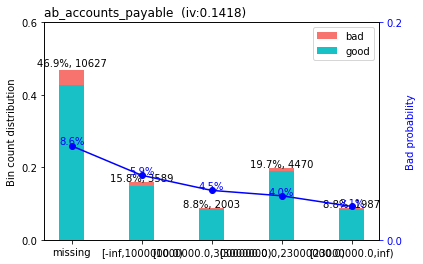

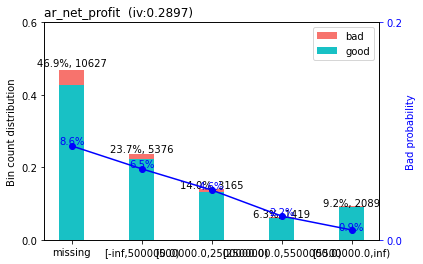

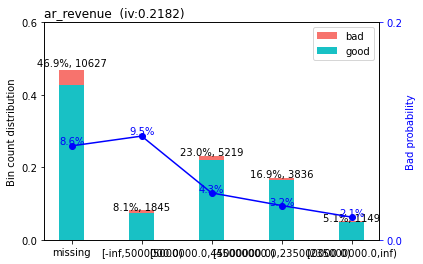

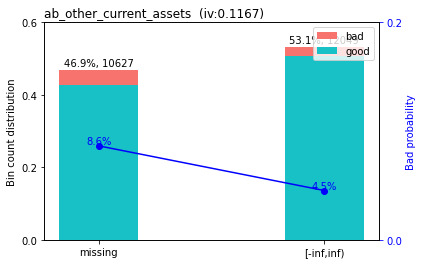

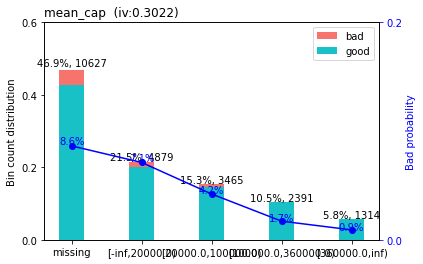

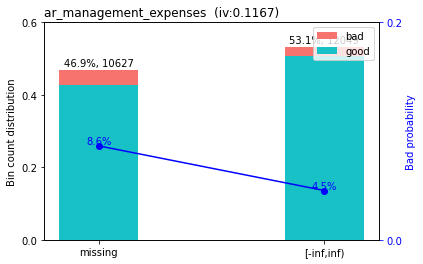

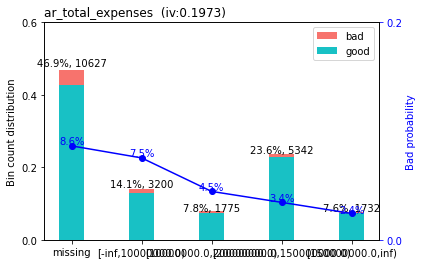

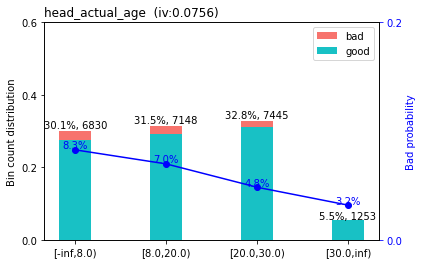

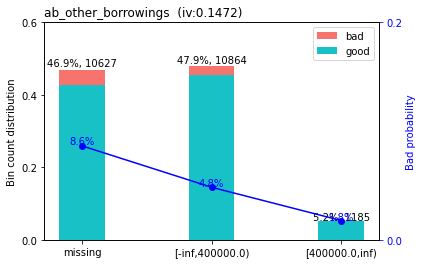

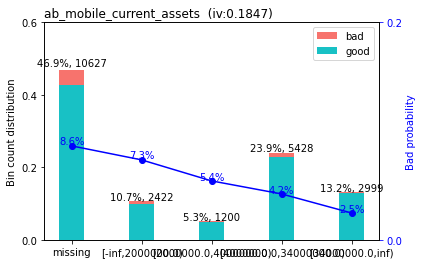

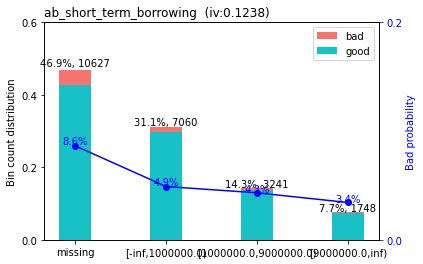

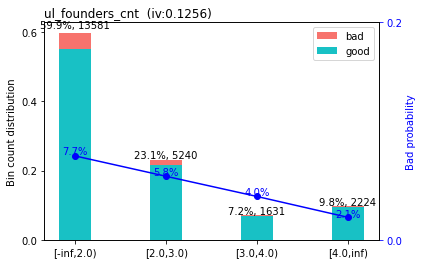

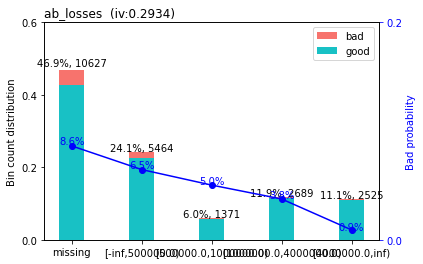

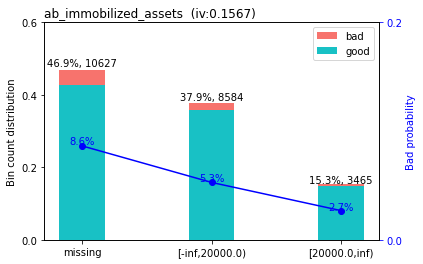

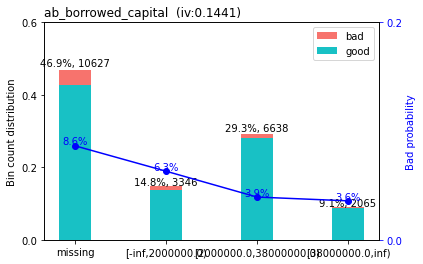

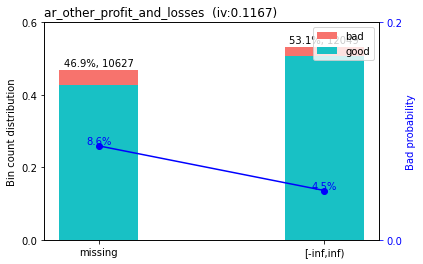

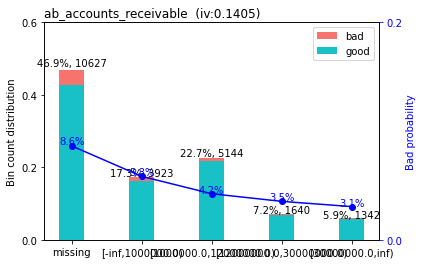

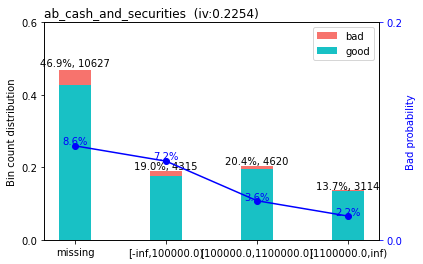

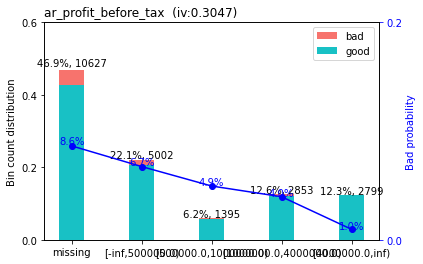

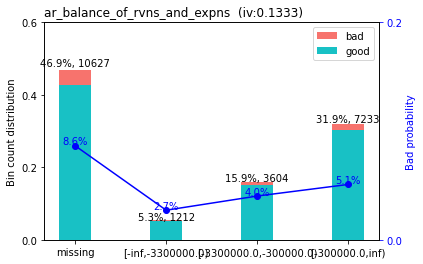

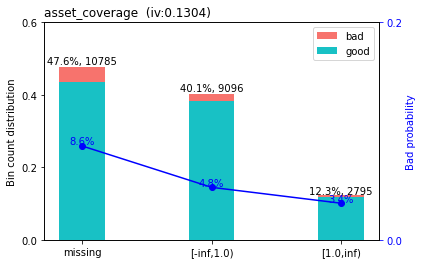

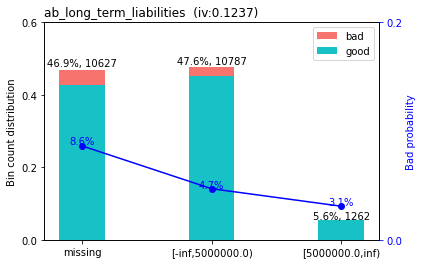

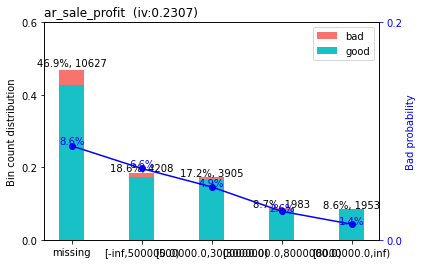

In [35]:
sc.woebin_plot(bins)
plt.show()

## Однофакторный анализ 

обучим модель на каждом признаке отдельно, посмотрим его уровень значимости, коэф регрес и gini. Проделаем это на train и test

ведем переменную flag, котрая будет означать, что коэф регрес изменил свое направление на train или test

после этого откинем признаки, которые:
- не прошли по p_val = 0.05
- coef регрессии изменил свое напровление на train или test
- gini < 0.1


In [36]:
from statsmodels.discrete.discrete_model import Logit

In [37]:
table = []
for i in X_train_woe.columns[1:]:
    Logit_train = Logit(X_train_woe['default_12m'], X_train_woe[i]).fit(disp = 0)
    coef_train = Logit_train.params.values[-1]
    p_val_train = Logit_train.pvalues.values[-1]
    pr_train = Logit_train.predict(X_train_woe[i])
    gini_train = roc_auc_score(X_train_woe['default_12m'], pr_train) * 2 -1
    
    Logit_test = Logit(X_test_woe['default_12m'], X_test_woe['ar_sale_cost_woe']).fit(disp = 0)
    coef_test = Logit_test.params.values[-1]
    p_val_test = Logit_test.pvalues.values[-1]
    pr_test = Logit_test.predict(X_test_woe[i])
    gini_test = roc_auc_score(X_test_woe['default_12m'], pr_test) * 2 -1
    
    flag = sign(coef_train) == sign(coef_test)
    table += [[i] + [coef_train] + [p_val_train] + [gini_train] + [coef_test] + [p_val_test] + [gini_test] + [flag]]
    
table_df = pd.DataFrame(table, columns=['name', 'coef_train', 'p_val_train', 'gini_train', \
                                                'coef_test', 'p_val_test', 'gini_test', 'flag'])

In [38]:
table_df_anova = table_df.loc[(table_df['p_val_train'] < 0.05) & (table_df['flag']  == True) & (table_df['gini_train'] > 0.1)].sort_values(by = ['p_val_train', 'p_val_test'])
table_df_anova

,name,coef_train,p_val_train,gini_train,coef_test,p_val_test,gini_test,flag
5,ogrn_age_woe,0.991030,1.824521e-294,0.273086,0.906195,6.548957e-97,0.261531,True
13,bus_age_woe,0.974926,1.096972e-288,0.268658,0.906195,6.548957e-97,0.277863,True
10,ab_own_capital_woe,0.775631,3.052720e-281,0.232923,0.906195,6.548957e-97,0.210364,True
19,mean_cap_woe,0.768670,4.149427e-269,0.230505,0.906195,6.548957e-97,0.201615,True
14,investment_woe,0.775858,4.728674e-262,0.229144,0.906195,6.548957e-97,0.207842,True
33,ar_profit_before_tax_woe,0.742902,2.607520e-256,0.226120,0.906195,6.548957e-97,0.207100,True
16,ar_net_profit_woe,0.751812,2.541802e-247,0.223503,0.906195,6.548957e-97,0.205034,True
27,ab_losses_woe,0.741986,1.130623e-244,0.222562,0.906195,6.548957e-97,0.204211,True
17,ar_revenue_woe,0.897846,2.222967e-239,0.229823,0.906195,6.548957e-97,0.206486,True
32,ab_cash_and_securities_woe,0.856389,2.333552e-237,0.221054,0.906195,6.548957e-97,0.206576,True


In [39]:
anova_list = list(table_df_anova['name'])
anova_list.append('default_12m')

In [40]:
X_train_woe_v1 = X_train_woe[anova_list]
X_test_woe_v1 = X_test_woe[anova_list]
oot_woe_v1 = oot_woe[anova_list[:-1]]

## Стабильность переменной 

Оценим стабильность переменной на 20-ти разных разбиениях train и test. 

Оставим только те призаки:
- коэф-нт вариации < 0.13
- min gini > 0.1



In [41]:
data_woe = pd.concat([X_train_woe_v1, X_test_woe_v1])

In [42]:
table_stab = []
for i in data_woe.columns[:-1]:
    gini_mas = []
    for n_iter in range(0, 21):
        (X_train_stab, X_test_stab) = train_test_split(data_woe, test_size=0.3, stratify = data['default_12m'], 
                                             random_state=n_iter)
        
        model = Logit(X_train_stab['default_12m'], X_train_stab[i]).fit(disp = 0)
        pred = model.predict(X_test_stab[i])
        gini = roc_auc_score(X_test_stab['default_12m'], pred) * 2 - 1
        gini_mas += [gini]
    gini_min = min(gini_mas)
    var = np.std(gini_mas) / np.mean(gini_mas)
    table_stab += [[i] + [var] + [gini_min]]

In [43]:
table_stab = pd.DataFrame(table_stab, columns=['name', 'coef_variation', 'gini_min'])
table_stab.sort_values(by = 'coef_variation')

,name,coef_variation,gini_min
4,investment_woe,0.063368,0.190582
0,ogrn_age_woe,0.063531,0.230631
2,ab_own_capital_woe,0.066604,0.194090
3,mean_cap_woe,0.069162,0.191487
5,ar_profit_before_tax_woe,0.069897,0.186720
1,bus_age_woe,0.070565,0.233139
7,ab_losses_woe,0.072157,0.184138
6,ar_net_profit_woe,0.072874,0.183888
9,ab_cash_and_securities_woe,0.073583,0.177286
13,mean_shareholder_woe,0.078690,0.173012


In [44]:
stab_list = list(table_stab.loc[(table_stab['coef_variation'] < 0.13) & (table_stab['gini_min'] > 0.1)]['name'])
stab_list.append('default_12m')

In [45]:
X_train_woe_v2 = X_train_woe_v1[stab_list]
X_test_woe_v2 = X_test_woe_v1[stab_list]
oot_woe_v2 = oot_woe_v1[stab_list[:-1]]

##  Чистка корреляторов

    
найдем пары признаков у которых корелляция пирсона > 0.8 и отбросим тот, у которого корреляция с целевой переменной меньше

In [46]:
from scipy.stats.stats import pearsonr
import itertools

In [47]:
def delcor(data, max_cor = 0.8):
    itog_col = list(data.columns)
    for i in data.columns:
        for j in data.columns:
            if i != j  and pearsonr(data[i], data[j])[0] > max_cor:
                if pearsonr(data[i], data['default_12m'])[0] > pearsonr(data[j], data['default_12m'])[0]:
                    if j in itog_col and j != 'default_12m':
                        itog_col.remove(j)
    return itog_col

<AxesSubplot:>

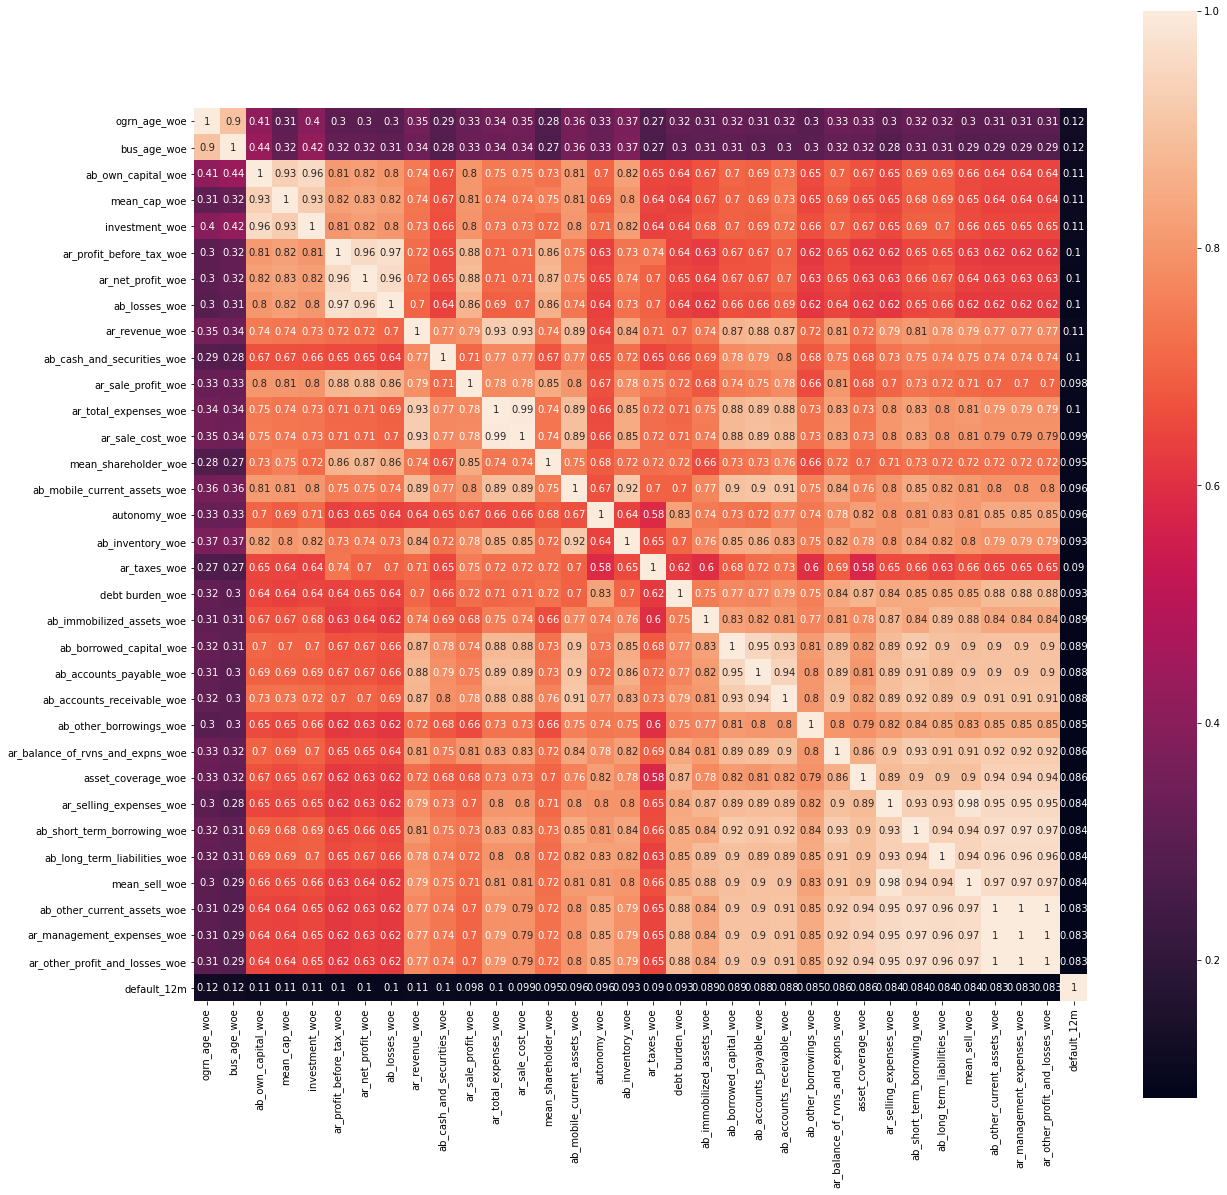

In [48]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train_woe_v2.corr(), square=True, annot = True)

<AxesSubplot:>

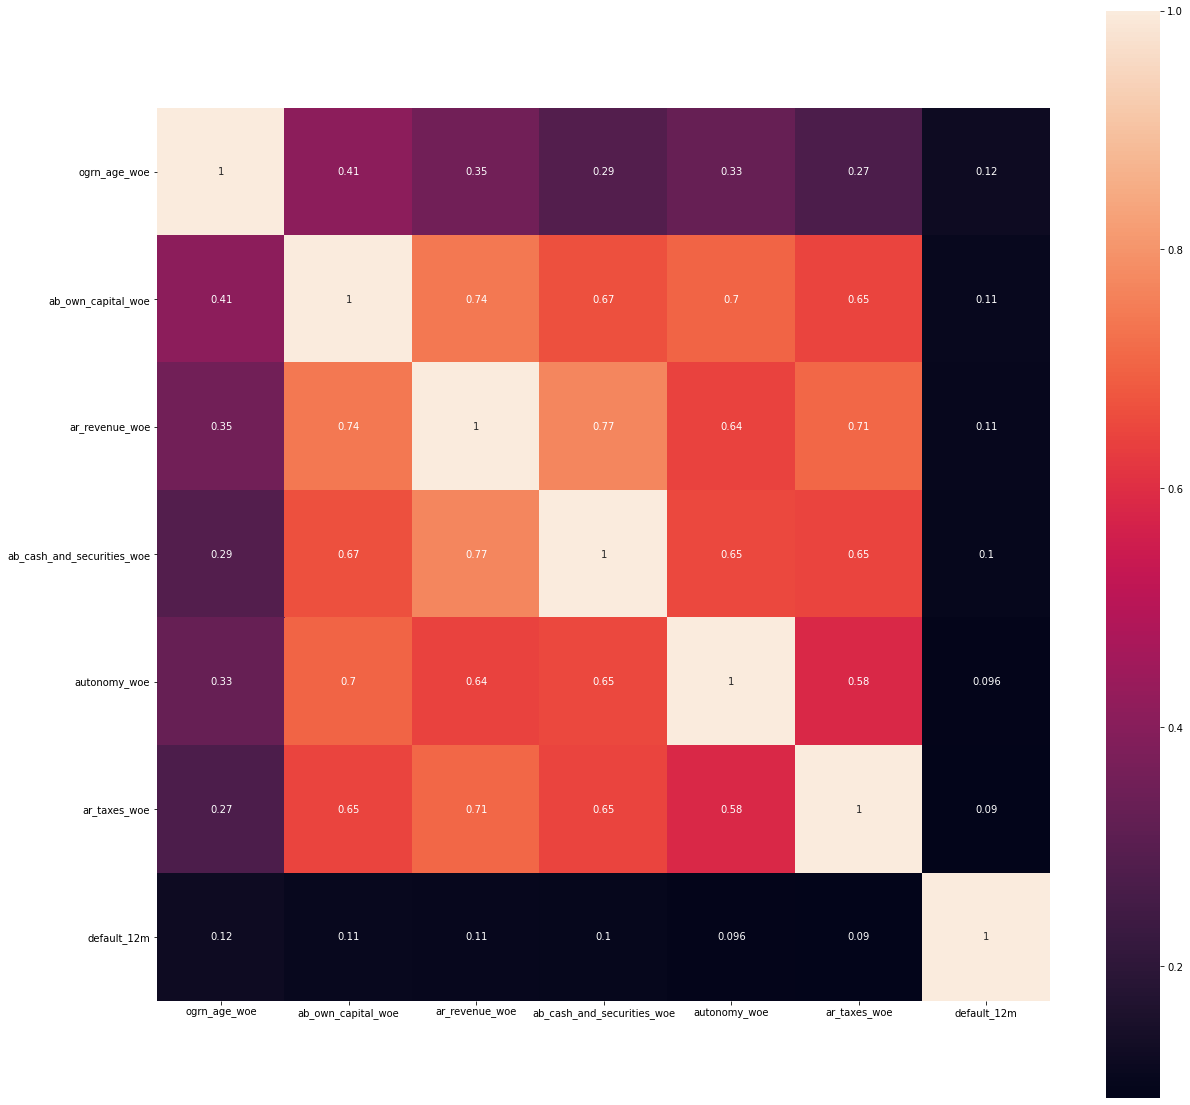

In [49]:
short_list = delcor(X_train_woe_v2)
plt.figure(figsize=(20, 20))
sns.heatmap(X_train_woe_v2[short_list].corr(), square=True, annot = True)

In [50]:
X_train_woe_short_v3 = X_train_woe_v2[short_list]
X_test_woe_short_v3 = X_test_woe_v2[short_list]
oot_woe_short_v3 = oot_woe_v2[short_list[:-1]]

## Многофакторный анализ 

### Проверка на мультиколлинеарность
удалим признаки где vif > 10

In [51]:
manova = pd.DataFrame()
manova["vif"] = [vif(X_train_woe_short_v3.values, i) for i in range(X_train_woe_short_v3.shape[1])]
manova["name"] = X_train_woe_short_v3.columns

In [52]:
manova

,vif,name
0,1.257797,ogrn_age_woe
1,3.136509,ab_own_capital_woe
2,3.758481,ar_revenue_woe
3,2.946994,ab_cash_and_securities_woe
4,2.364392,autonomy_woe
5,2.333400,ar_taxes_woe
6,1.004955,default_12m


In [53]:
short_list = list(manova.loc[manova['vif'] < 10]['name'].values)

In [54]:
X_train_woe_short_v4 = X_train_woe_short_v3[short_list]
X_test_woe_short_v4 = X_test_woe_short_v3[short_list]
oot_woe_short_v4 = oot_woe_short_v3[short_list[:-1]]

# Модель

### сначало попробуем визуализировать все признаки

желтыми точками отметим клиентов с дефолтом

Populating the interactive namespace from numpy and matplotlib


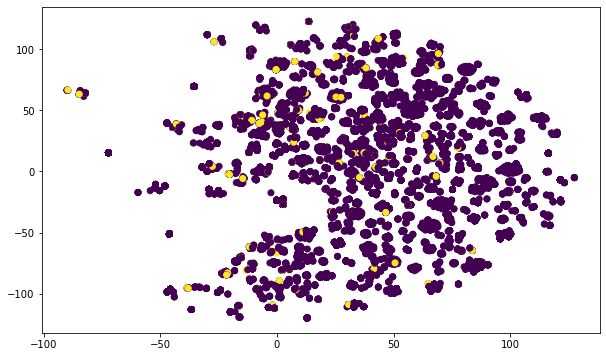

In [55]:
%pylab inline
from sklearn import manifold

tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0, n_jobs = -1)
data_2d_tsne = tsne.fit_transform(X_train_woe_short_v4.drop('default_12m', axis = 1))

pylab.figure(figsize = (10, 6))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = X_train_woe_short_v4['default_12m'])

### Построим LogReg найдя лучшие параметры перебором по GridSearchCV
будем подбирать :
- силу регуляризации
- тип регуляризации
- алгоритм оптимизации

In [56]:
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt

In [70]:
X_train_itog = X_train_woe_short_v4.drop('default_12m', axis = 1)
y_train_itog = X_train_woe_short_v4['default_12m']
X_test_itog = X_test_woe_short_v4.drop('default_12m', axis = 1)
y_test_itog = X_test_woe_short_v4['default_12m']

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2.5, 5, 7.5, 10],
             'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty' : ['l1', 'l2']}
estimator = LogisticRegression(random_state = 0, class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid, cv = 3, scoring='roc_auc')
optimizer.fit(X_train_itog, y_train_itog)

pred0 = optimizer.predict_proba(X_train_itog)
fpr0, tpr0, _ = roc_curve(y_train_itog, pred0[:, 1])
roc_auc0 = roc_auc_score(y_train_itog, pred0[:, 1])

pred = optimizer.predict_proba(X_test_itog)
fpr, tpr, _ = roc_curve(y_test_itog, pred[:, 1])
roc_auc = roc_auc_score(y_test_itog, pred[:, 1])
roc_auc

0.6623574469309297

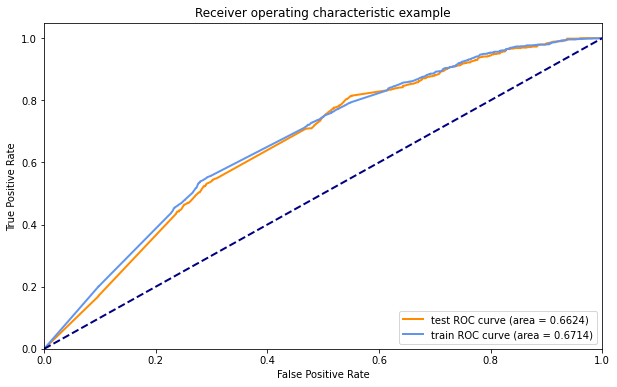

In [73]:
plt.figure(figsize=[10,6])
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='test ROC curve (area = %0.4f)' % roc_auc)

plt.plot(fpr0, tpr0, color='cornflowerblue',
         lw=2, label='train ROC curve (area = %0.4f)' % roc_auc0)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [74]:
print(classification_report(y_test_itog, optimizer.predict(X_test_itog)))

              precision    recall  f1-score   support

           0       0.96      0.51      0.67      9092
           1       0.09      0.73      0.16       627

    accuracy                           0.53      9719
   macro avg       0.53      0.62      0.42      9719
weighted avg       0.91      0.53      0.64      9719



мы не добучились на 1 классе , но судя по графику, не переобучились на train

## Валидация результата

In [62]:
X = pd.concat([X_test_woe_short_v4, X_train_woe_short_v4])
y = X['default_12m']
X = X.drop('default_12m', axis = 1)

In [63]:
def write_ans(x, name = ''):
    answ_df = pd.DataFrame()
    answ_df['id'] = record_id
    answ_df['predict'] = x
    answ_df.to_csv('PD-submit' + name +'.csv',index=False, sep=';')

In [64]:
optimizer.fit(X, y)
pr = optimizer.predict(oot_woe_short_v4)

In [157]:
write_ans(pr2, '10.7')

In [66]:
# for i, j in zip(estimator.coef_[0], X.columns):
#     print(j, round(i, 4))

In [75]:
pr

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0])

In [76]:
len(pr[pr == 1]), len(pr[pr == 0])

(131, 69)